# Calculate uncertainty on BTs (notebook)

### Import python package for plotting.

In [2]:
# This requires jupyter-matplotlib a.k.a. ipympl.
# ipympl can be install via pip or conda.
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
import numpy as np
import pandas as pd
np.seterr('raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### Import pyrtlib package and tools

In [3]:
from pyrtlib.absorption_model_uncertainty import absmod_uncertainties_perturb, AMU
from pyrtlib.atmospheric_profiles import AtmosphericProfiles as atmp
from pyrtlib.main import BTCloudRTE
from pyrtlib.utils import ppmv2gkg, mr2rh, get_frequencies
from pyrtlib.lineshape import covariance_matrix

In [4]:
atm = ['Tropical',
       'Midlatitude Summer',
       'Midlatitude Winter',
       'Subarctic Summer',
       'Subarctic Winter',
       'U.S. Standard']

### Define spectroscopic parameters to be perturbed

In [5]:
# O2 parameters
O2_parameters = {'O2S': [None],
                 'X05': [None],
                 'WB300': [None],
                 'O2gamma': [],
                 'Y300': [],
                 'O2_V': []}

for i in range(0, 34):
    O2_parameters['O2gamma'].append(i)
    O2_parameters['Y300'].append(i)
    O2_parameters['O2_V'].append(i)

O2_uncertainties = {'O2S': [np.mean(AMU['O2S'].uncer / AMU['O2S'].value) * 100],
                    'X05': [AMU['X05'].uncer],
                    'WB300': [AMU['WB300'].uncer],
                    'O2gamma': AMU['O2gamma'].uncer[0: 34].tolist(),
                    'Y300': AMU['Y300'].uncer[0: 34].tolist(),
                    'O2_V': AMU['O2_V'].uncer[0: 34].tolist()}

# %%
# H2O parameters
HO2_parameters = {'con_Cf_factr': [None],
                  'con_Cs_factr': [None],
                  'gamma_a': [0],
                  'S': [0],
                  'con_Xf': [None],
                  'SR': [0],
                  'con_Xs': [None]
                  }

H2O_uncertainties = {'con_Cf_factr': [AMU['con_Cf'].value * AMU['con_Cf_factr'].uncer],
                     'con_Cs_factr': [AMU['con_Cs'].value * AMU['con_Cs_factr'].uncer],
                     'gamma_a': [AMU['gamma_a'].uncer[0]],
                     'S': [AMU['S'].uncer[0]],
                     'con_Xf': [AMU['con_Xf'].uncer],
                     'SR': [AMU['SR'].uncer[0]],
                     'con_Xs': [AMU['con_Xs'].uncer]
                     }

# HO2_parameters = {}
# H2O_uncertainties = {}
# %%
uncertainties_all = [item for sublist in list((O2_uncertainties | H2O_uncertainties).values()) for item in sublist]

Load standard atmosphere (low res at lower levels, only 1 level within 1 km) and define which absorption model will be used.

In [6]:
z, p, _, t, md = atmp.gl_atm(atmp.TROPICAL)

gkg = ppmv2gkg(md[:, atmp.H2O], atmp.H2O)
rh = mr2rh(p, t, gkg)[0] / 100

### Use frequencies set of HATPRO Radiometer

In [ ]:
frq = sorted(list(set().union(get_frequencies('hat'), np.arange(20, 61, 1).tolist())))

### Performing uncertainty of brightness temperature

Default calculatoin consideres no cloud and no perturbation

In [ ]:
amu_p = absmod_uncertainties_perturb()
rte = BTCloudRTE(z, p, t, rh, frq, amu=amu_p)
rte.satellite = False
rte.init_absmdl('uncertainty')
df = rte.execute()

In [8]:
df_out = pd.DataFrame()
df_out['freq'] = frq
df_out['tb'] = df.tbtotal

### Calculate Jacobian matrix

$$Cov(T_{b}) = K_{p} \times Cov(p) \times K_{p}^T$$

In [9]:
cnt = 0
for k, v in (O2_parameters | HO2_parameters).items():
    for i in v:
        amu_p = absmod_uncertainties_perturb([k], 'max', index=i)
        rte.set_amu(amu_p)
        df = rte.execute()
        field_name = 'Kb_{}{}'.format(k, '_' + str(i) if i else '')
        df_out[field_name] = (df.tbtotal - df_out.tb) / uncertainties_all[cnt]
        cnt += 1

### Calculate uncertainty (sigma) for BT

In [10]:
Kp = df_out.loc[:, ~df_out.columns.isin(['tb', 'freq'])].values

covtb = np.matmul(np.matmul(Kp, covariance_matrix.rose17), Kp.T)

sigma_tb = np.sqrt(np.diag(covtb))

df_out['sigma_tb'] = sigma_tb

<AxesSubplot:title={'center':'${T_B}$ uncertainty due to uncertainties in ${O_2}$ and ${H_2 O}$ parameters'}, xlabel='Frequency [GHz]', ylabel='$\\sigma_{T_B}$ [K]'>

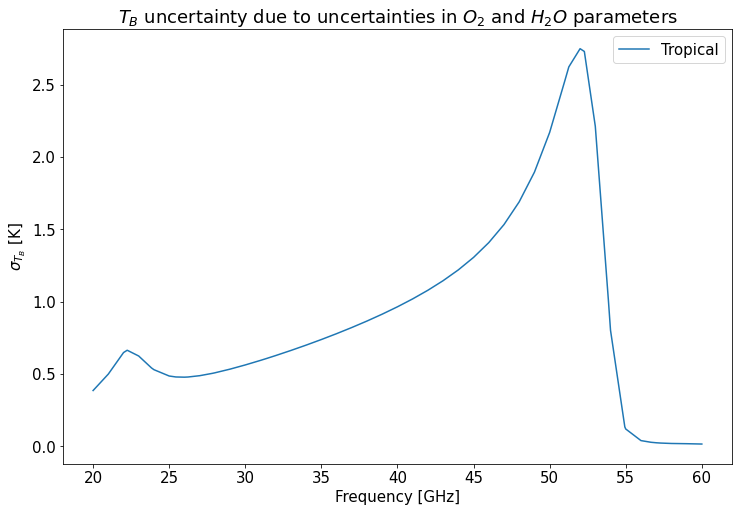

In [12]:
df_out.plot(x='freq', y='sigma_tb',
            title="${T_B}$ uncertainty due to uncertainties in ${O_2}$ and ${H_2 O}$ parameters",
            xlabel='Frequency [GHz]', ylabel='$\sigma_{T_B}$ [K]',
            label=atm[atmp.TROPICAL], figsize=(12,8))